In [31]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [33]:
csv_dir = '../my-data'
dfs_1, dfs_2 = [], []
for csv in os.listdir(csv_dir):
    df = pd.read_csv(os.path.join(csv_dir, csv), index_col=0, dtype=float)
    df.drop(columns=["0.5"], inplace=True)
    if csv.endswith('1.csv'):
        dfs_1.append(df)
    elif csv.endswith('2.csv'):
        dfs_2.append(df)

chiller_temps = [pd.concat(dfs) for dfs in zip(dfs_1, dfs_2)]
df_concat = pd.concat(chiller_temps)
df_grouped = df_concat.groupby(df_concat.index)
avg_temp = df_grouped.max()
avg_temp.drop(index=[210.0, 240.0, 270.0, 300.0, 330.0], inplace=True)
avg_temp.head(13)

,1.25,2.0,2.75,3.5,4.25,5.0,5.75,6.5,7.25
0.0,2.3703,2.1481,2.5629,3.4393,4.0825,5.6261,6.8660,7.5000,7.3835
30.0,2.3282,3.6836,4.6876,4.1669,3.7088,4.0085,5.3438,6.5479,7.3065
60.0,3.2721,3.8536,4.1946,4.8841,5.0730,4.5068,4.8249,5.6620,6.1023
90.0,2.4132,2.5751,2.9767,3.7512,4.2699,5.0396,3.8903,4.1736,6.0842
120.0,3.1701,5.0859,5.5402,5.0749,4.9000,4.7430,4.6373,4.5207,4.3112
150.0,2.9602,3.7203,4.7100,4.3392,4.1675,3.9531,3.6568,3.4943,3.3190
180.0,3.1168,3.6944,4.2351,4.5522,4.1500,3.8579,3.5080,3.2345,2.9968


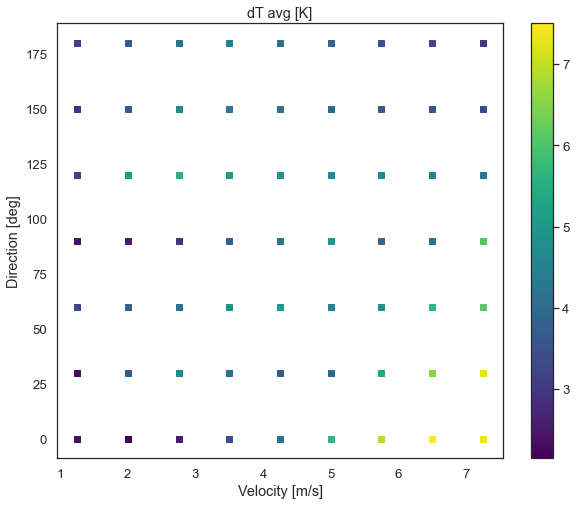

In [34]:
X1_obs = [float(i) for i in avg_temp.columns.tolist()]
X2_obs = [float(i) for i in avg_temp.index.tolist()]
x1, x2 = np.meshgrid(X1_obs, X2_obs)
x11 = sum(x1.tolist(), [])
x22 = sum(x2.tolist(), [])
# x1, x2 = np.meshgrid(np.linspace(0,360,nx1), np.linspace(0,8,nx2))
# X = np.concatenate([x1.reshape(nx1*nx2, 1), x2.reshape(nx1*nx2, 1)], 1)

# X1_obs = chiller_temp.columns.tolist()
# X2_obs = chiller_temp.index.tolist()
y_obs = sum(avg_temp.values.tolist(), [])

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11, x22, c=y_obs, marker='s', cmap=plt.cm.viridis)
    plt.xlabel("Velocity [m/s]")
    plt.ylabel("Direction [deg]")
    plt.title("dT avg [K]")
    plt.colorbar()

In [35]:
X_obs = np.concatenate([x1.reshape(len(x1)*len(x1[0]), 1), x2.reshape(len(x2)*len(x2[0]), 1)], axis=1)

In [36]:
RANDOM_SEED = 42
CHAINS = 4

In [37]:
with pm.Model() as model_1:
    
    # l1 = pm.StudentT("l1", nu=5, mu=3, sigma=2)
    l1_1 = pm.Normal("l1", mu=3, sigma=1)
    # l2 = pm.StudentT("l2", nu=15, mu=30, sigma=10)
    l2_1 = pm.Normal("l2", mu=30, sigma=2)
    sf_1 = pm.HalfCauchy("sf", 2)
    sn_1 = pm.HalfNormal("sn", 0.2)

    #M = pm.gp.mean.Constant([2.5])
    M_1 = pm.gp.mean.Zero()
    K_1 = pm.gp.cov.ExpQuad(2, [l1_1, l2_1]) * sf_1**2
    
    gp_chillers_1 = pm.gp.Marginal(mean_func=M_1, cov_func=K_1)
    obs_1 = gp_chillers_1.marginal_likelihood("obs_1", X=X_obs, y=y_obs, noise=sn_1)

    # mp = pm.find_MAP()

In [38]:
with pm.Model() as model_2:
    
    #l1_2 = pm.Normal("l1", mu=5, sigma=2)
    #l1_2 = pm.ChiSquared("l1", nu=6)
    #l1_2 = pm.ExGaussian("l1", mu=5, sigma=2, nu=1)
    #l1_2 = pm.Gamma("l1", mu=5, sigma=3)
    l1_2 = pm.Rice("l1", nu=4, sigma=1)
    #l2_2 = pm.Normal("l2", mu=40, sigma=10)
    #l2_2 = pm.ChiSquared("l2", nu=15)
    #l2_2 = pm.ExGaussian("l2", mu=40, sigma=10, nu=1)
    #l2_2 = pm.Gamma("l2", mu=30, sigma=10)
    l2_2 = pm.Rice("l2", nu=180, sigma=70)
    #sf_2 = pm.HalfCauchy("sf", 2)
    #sf_2 = pm.HalfStudentT("sf", sigma=3, nu=1)
    sf_2 = pm.Rice("sf", nu=5, sigma=2)
    sn_2 = pm.HalfNormal("sn", 0.6)

    #M = pm.gp.mean.Constant([2.5])
    M_2 = pm.gp.mean.Zero()
    K_2 = pm.gp.cov.ExpQuad(2, [l1_2, l2_2]) * sf_2**2
    
    gp_chillers_2 = pm.gp.Marginal(mean_func=M_2, cov_func=K_2)
    obs_2 = gp_chillers_2.marginal_likelihood("obs_2", X=X_obs, y=y_obs, noise=sn_2)

In [39]:
with model_1:
    gp_trace_1 = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sn, sf, l2, l1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 47 seconds.
The acceptance probability does not match the target. It is 0.8846018218572976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863452161815596, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7037907769899454, but should be close to 0.8. Try to increase the number of tuning steps.


In [40]:
with model_2:
    gp_trace_2 = pm.sample(1000, tune=3000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sn, sf, l2, l1]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 56 seconds.


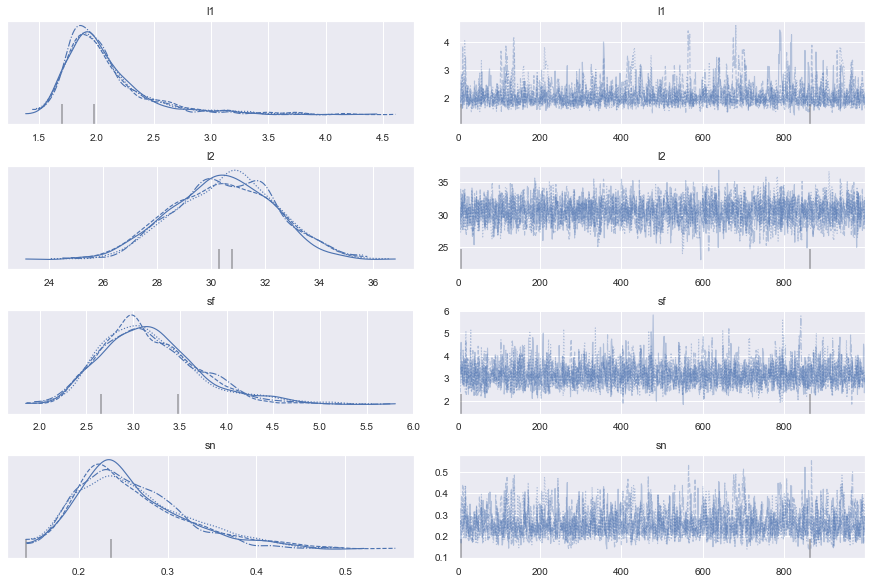

In [41]:
az.plot_trace(gp_trace_1, var_names=['l1', 'l2', 'sf', 'sn']);

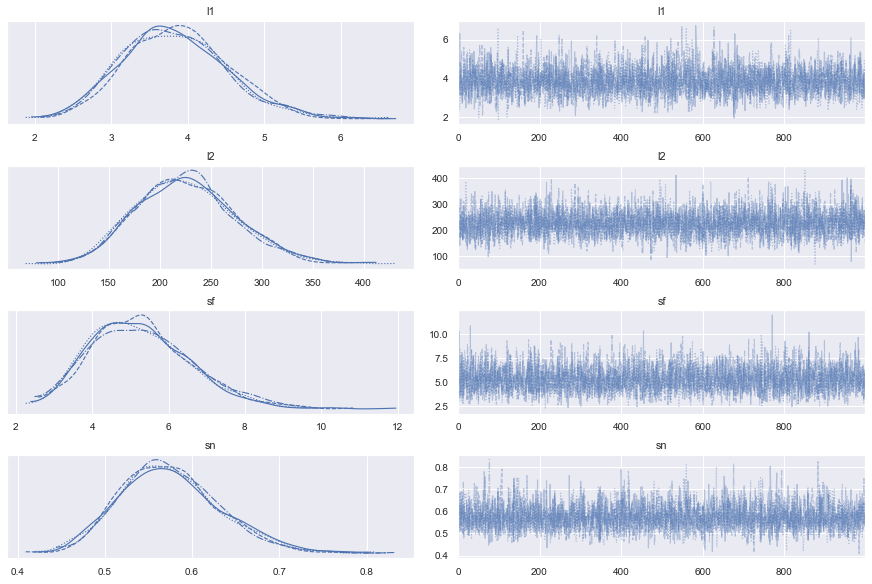

In [42]:
az.plot_trace(gp_trace_2, var_names=['l1', 'l2', 'sf', 'sn']);

array([<AxesSubplot:title={'center':'l1'}>,
       <AxesSubplot:title={'center':'l2'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

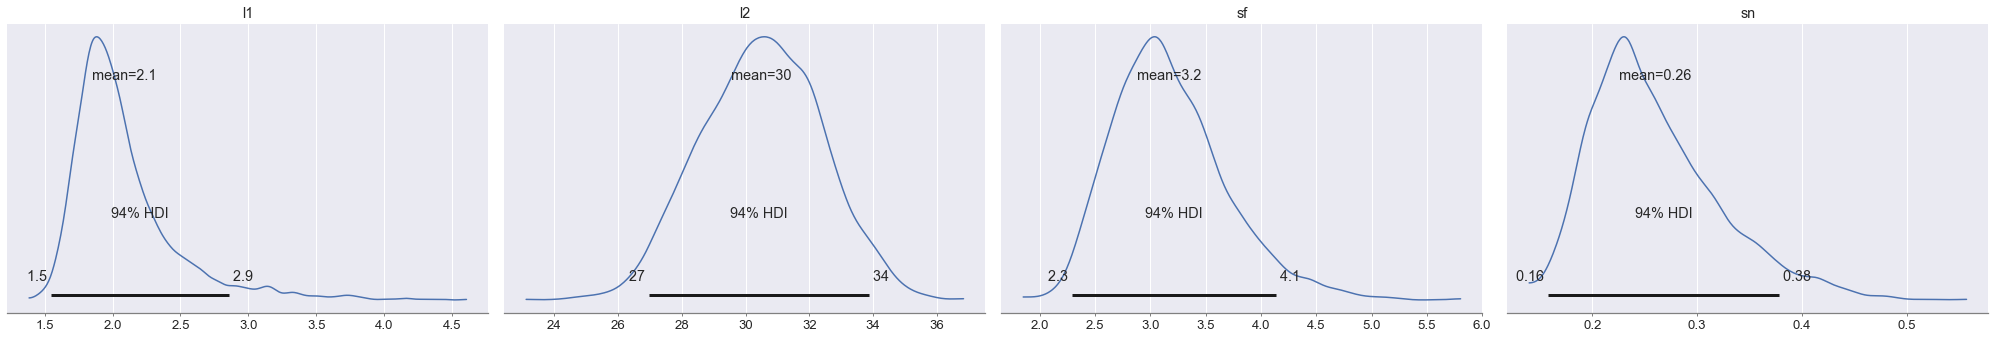

In [43]:
az.plot_posterior(gp_trace_1)

array([<AxesSubplot:title={'center':'l1'}>,
       <AxesSubplot:title={'center':'l2'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

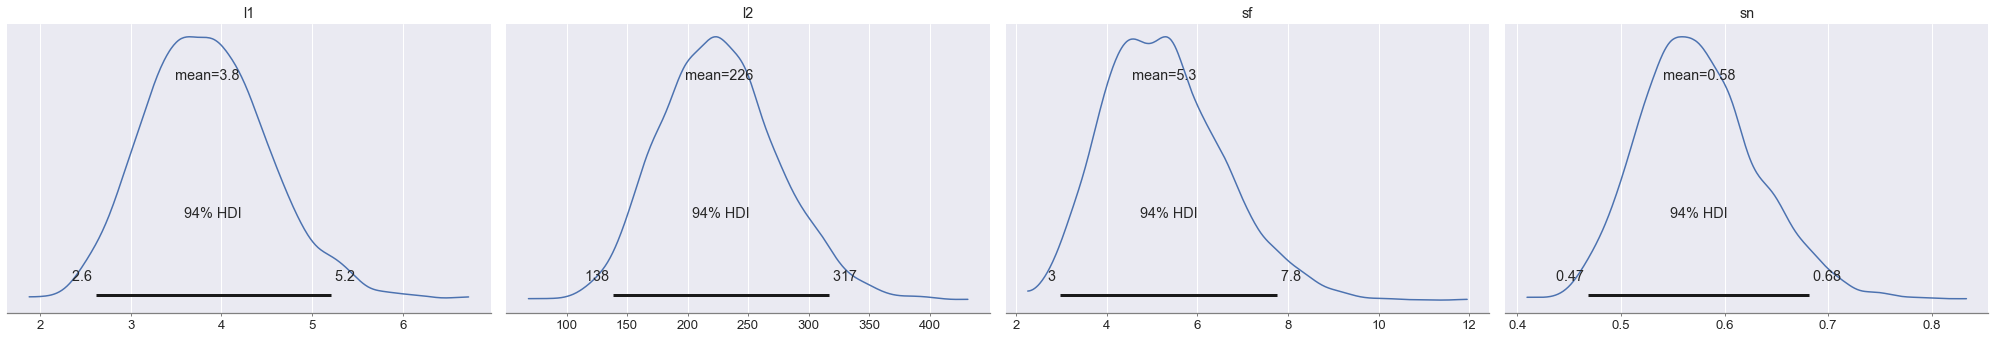

In [44]:
az.plot_posterior(gp_trace_2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

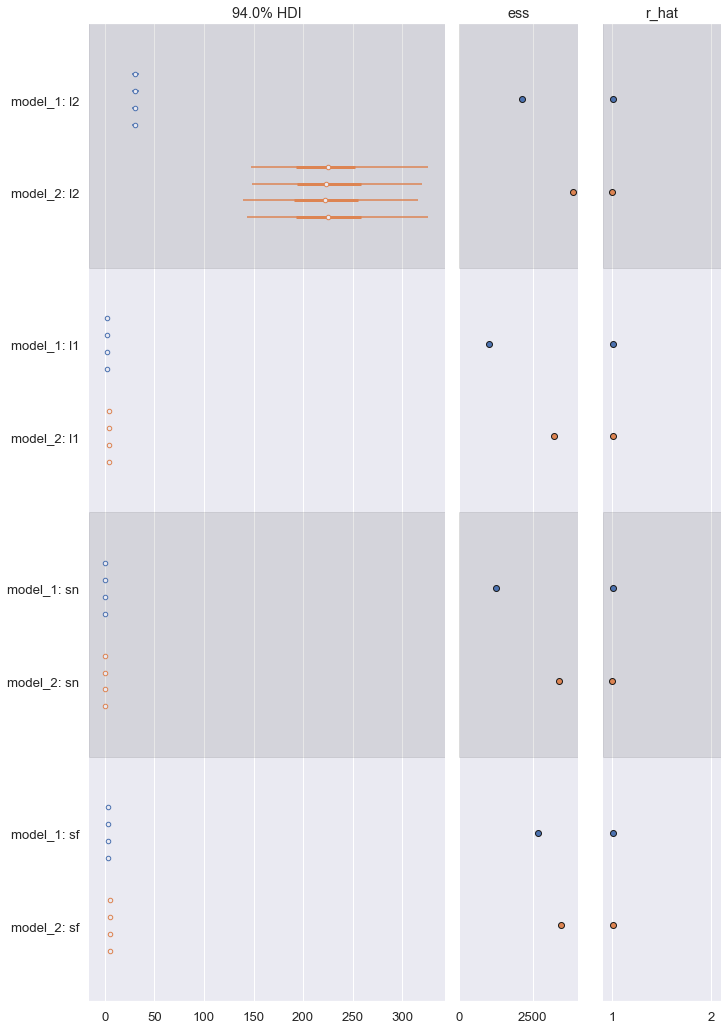

In [45]:
az.plot_forest([gp_trace_1, gp_trace_2], model_names=['model_1', 'model_2'], ess=True, r_hat=True)

In [46]:
az.summary(gp_trace_1, round_to=3, var_names=['l1', 'l2', 'sf', 'sn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l1,2.085,0.397,1.543,2.854,0.012,0.009,1648.394,935.387,1.003
l2,30.498,1.879,26.970,33.853,0.041,0.029,2145.253,1957.345,1.002
sf,3.173,0.518,2.290,4.140,0.010,0.007,2893.894,2242.221,1.000
sn,0.260,0.062,0.158,0.378,0.002,0.001,1447.830,1348.354,1.002


In [47]:
az.summary(gp_trace_2, round_to=3, var_names=['l1', 'l2', 'sf', 'sn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l1,3.844,0.695,2.613,5.207,0.012,0.009,3245.310,2734.375,1.001
l2,226.310,48.712,138.297,316.976,0.781,0.553,3850.386,2584.736,1.002
sf,5.276,1.311,2.981,7.763,0.022,0.016,3424.107,2939.919,1.001
sn,0.575,0.058,0.468,0.682,0.001,0.001,3590.801,2637.922,1.001


In [48]:
loo_1 = az.loo(gp_trace_1, model_1)
loo_1.loo

-77.84249944193192

In [49]:
loo_2 = az.loo(gp_trace_2, model_2)
loo_2.loo

-73.89882192831234

In [50]:
df_comp_loo = az.compare({"model_1": gp_trace_1, "model_2": gp_trace_2})
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-73.898822,1.841791,0.000000,1.000000e+00,0.0,0.0,True,log
model_1,1,-77.842499,2.214718,3.943678,2.220446e-16,0.0,0.0,True,log


In [51]:
nv = 18
nd = 14
ws = np.linspace(0.5, 10, nv)
wd = np.linspace(10, 170, nd)
t1, t2 = np.meshgrid(ws, wd)
T = np.concatenate([t1.reshape(len(t1)*len(t1[0]), 1), t2.reshape(len(t2)*len(t2[0]), 1)], axis=1)

In [52]:
with model_1:

    f_pred_1 = gp_chillers_1.conditional('f_pred_1', T)
    
    samples_1 = pm.sample_posterior_predictive([gp_trace_1], var_names=['f_pred_1'], random_seed=RANDOM_SEED, samples=100)

In [53]:
with model_2:

    f_pred_2 = gp_chillers_2.conditional('f_pred_2', T)
    
    samples_2 = pm.sample_posterior_predictive([gp_trace_2], var_names=['f_pred_2'], random_seed=RANDOM_SEED, samples=100)

In [54]:
s_1 = samples_1['f_pred_1'].mean(axis=0).reshape(nd, nv)
sd_1 = samples_1['f_pred_1'].std(axis=0).reshape(nd, nv)
s_2 = samples_2['f_pred_2'].mean(axis=0).reshape(nd, nv)
sd_2 = samples_2['f_pred_2'].std(axis=0).reshape(nd, nv)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

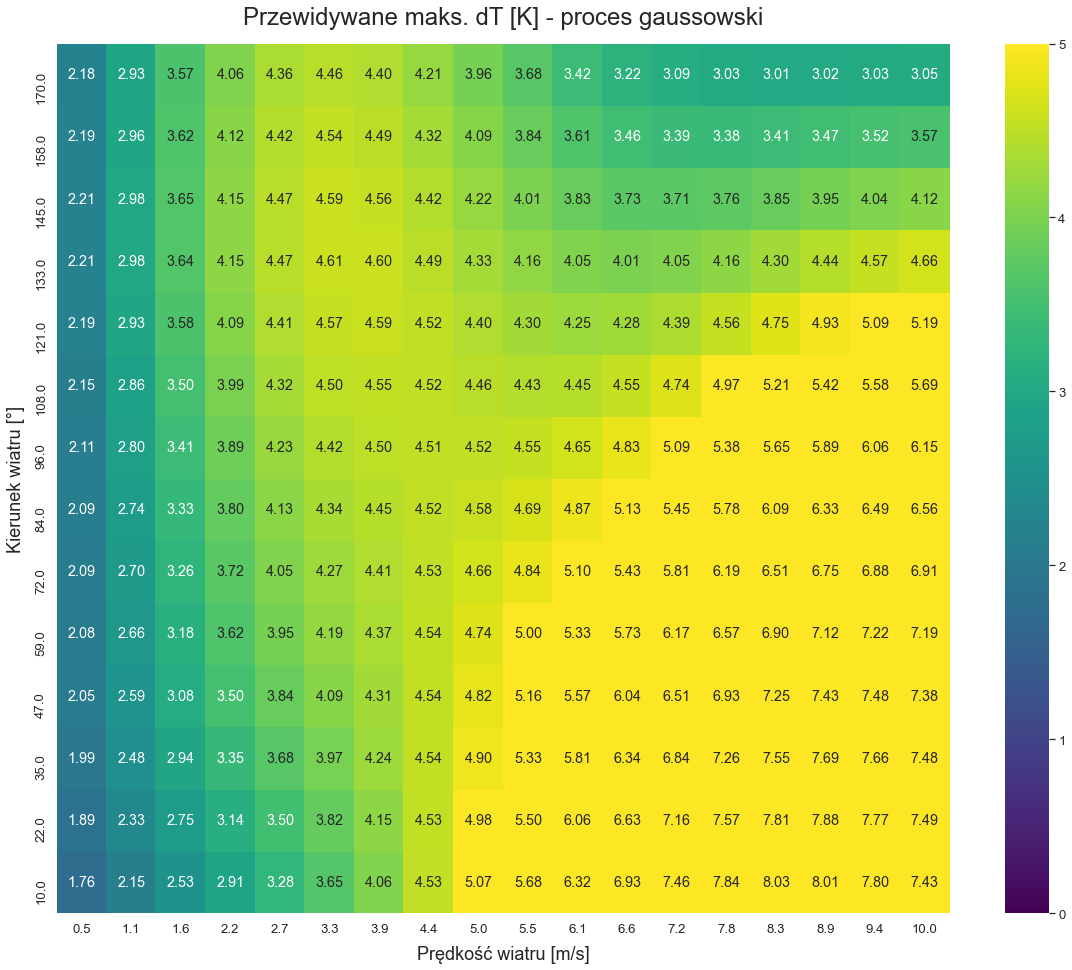

In [55]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_2, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane maks. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

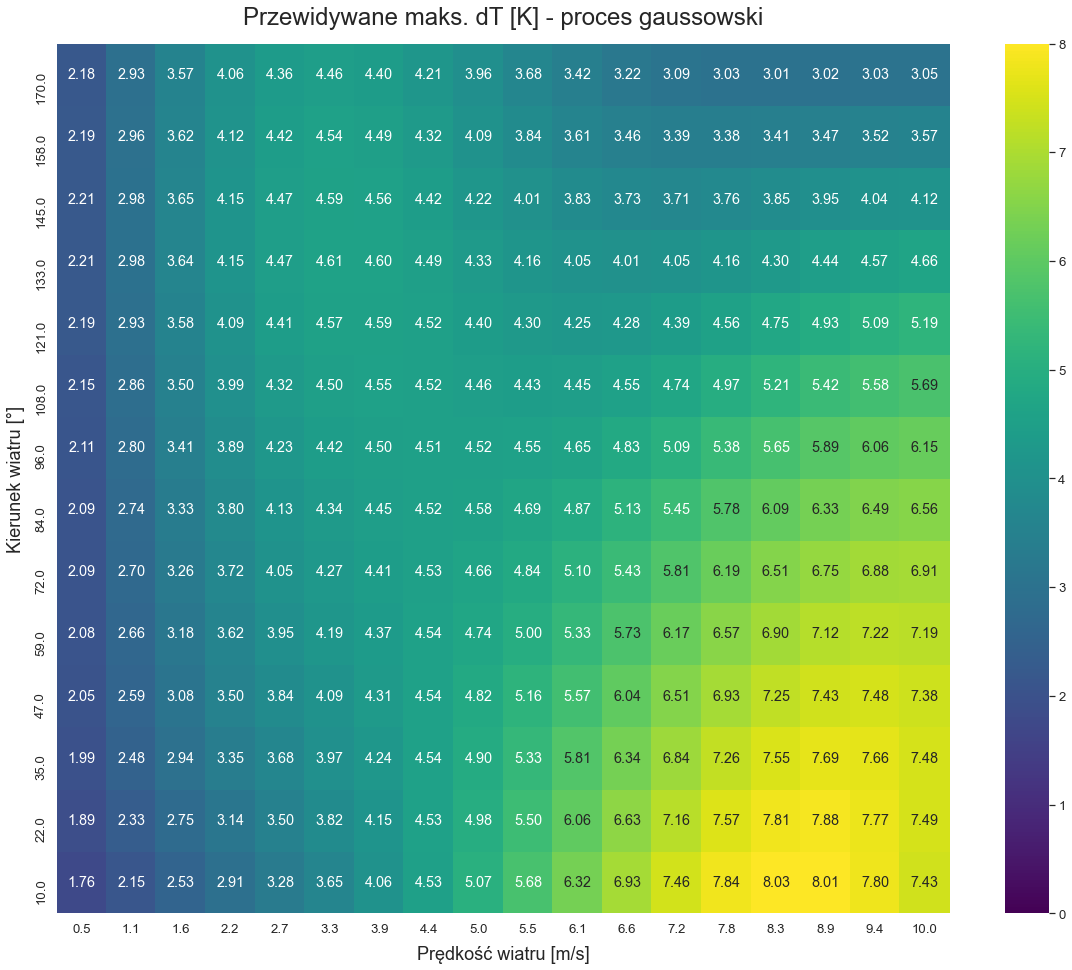

In [56]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_2, vmin=0, vmax=8, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane maks. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 1.0, 'Uncertainty - model_1')

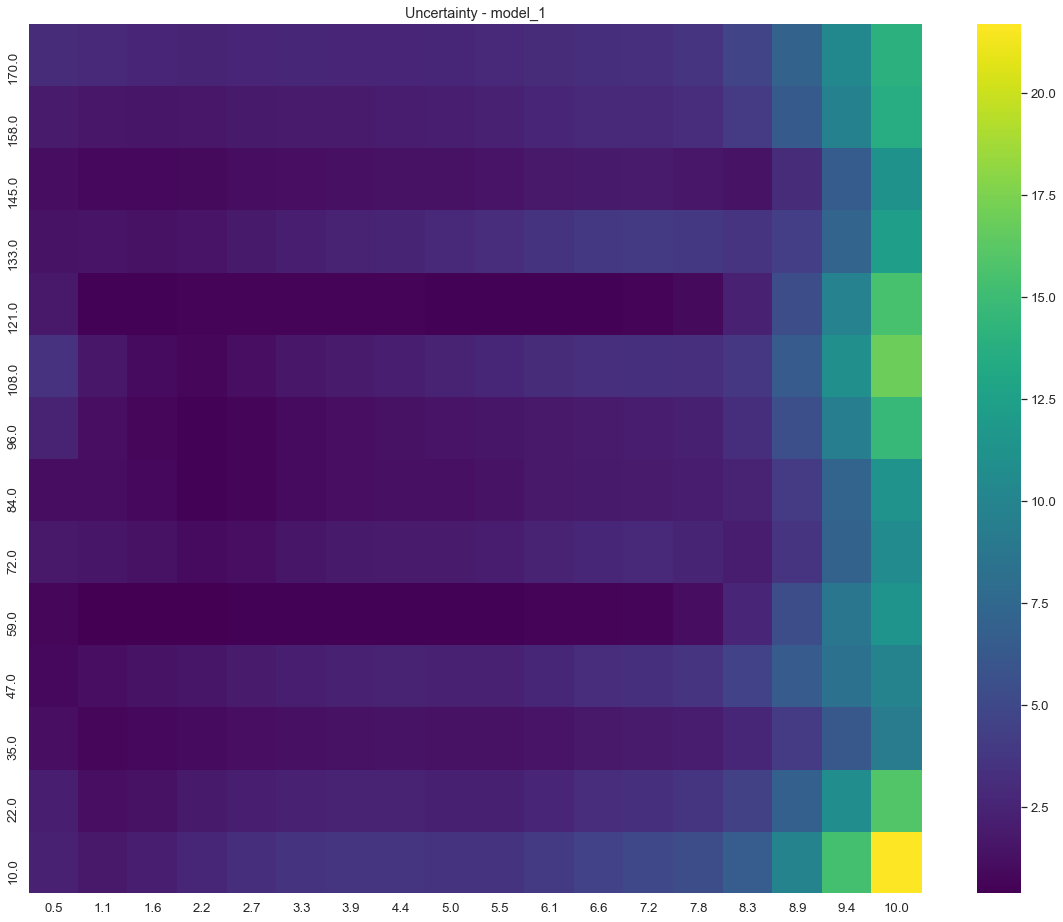

In [57]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_1, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Uncertainty - model_1')

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

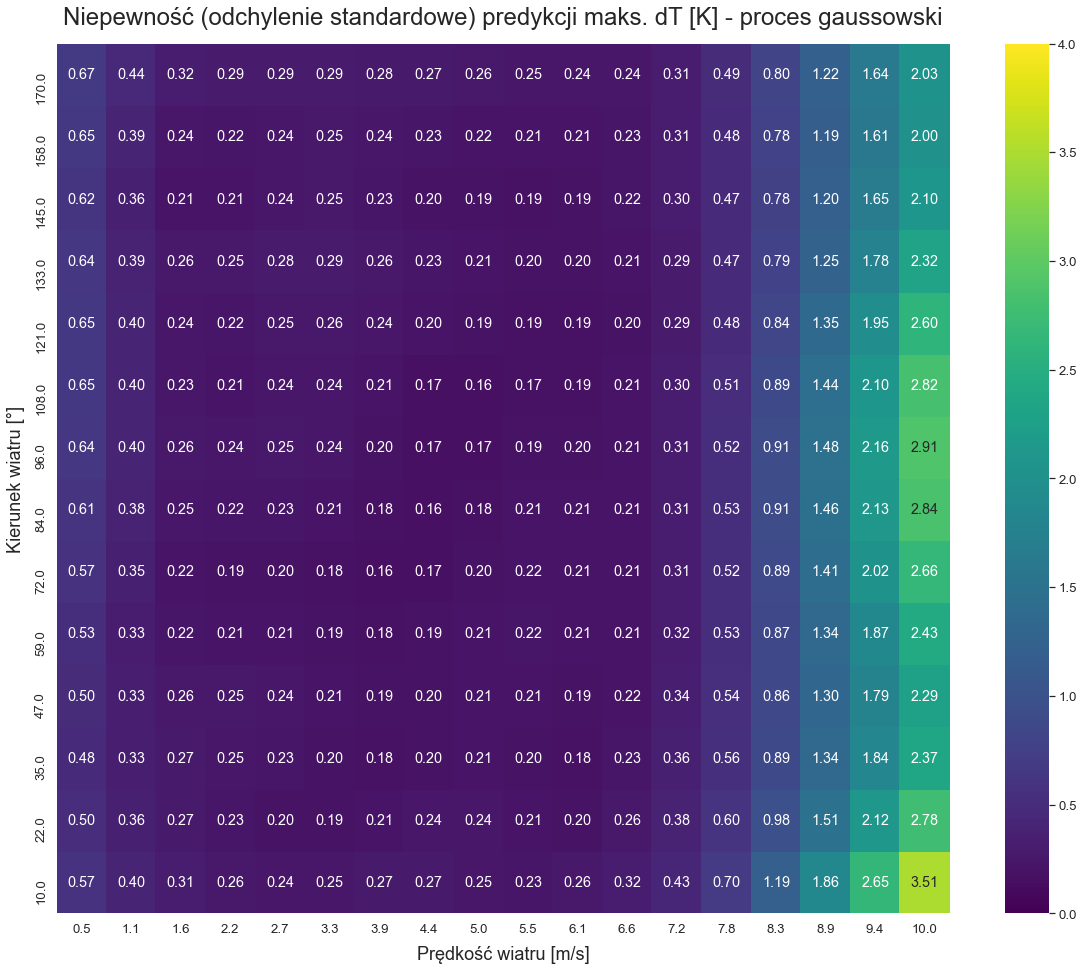

In [58]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_2, vmin=0, vmax=4, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Niepewność (odchylenie standardowe) predykcji maks. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)